In [1]:
from pylab import matplotlib, plt, np
import cv2
from tqdm import trange
from PIL import Image
from pathlib import Path
import shutil
import os
import random

image_path = r"./source_data/9700x8000-origin-db.jpg"
label_path = r"./source_data/9700x8000-mask005.png"

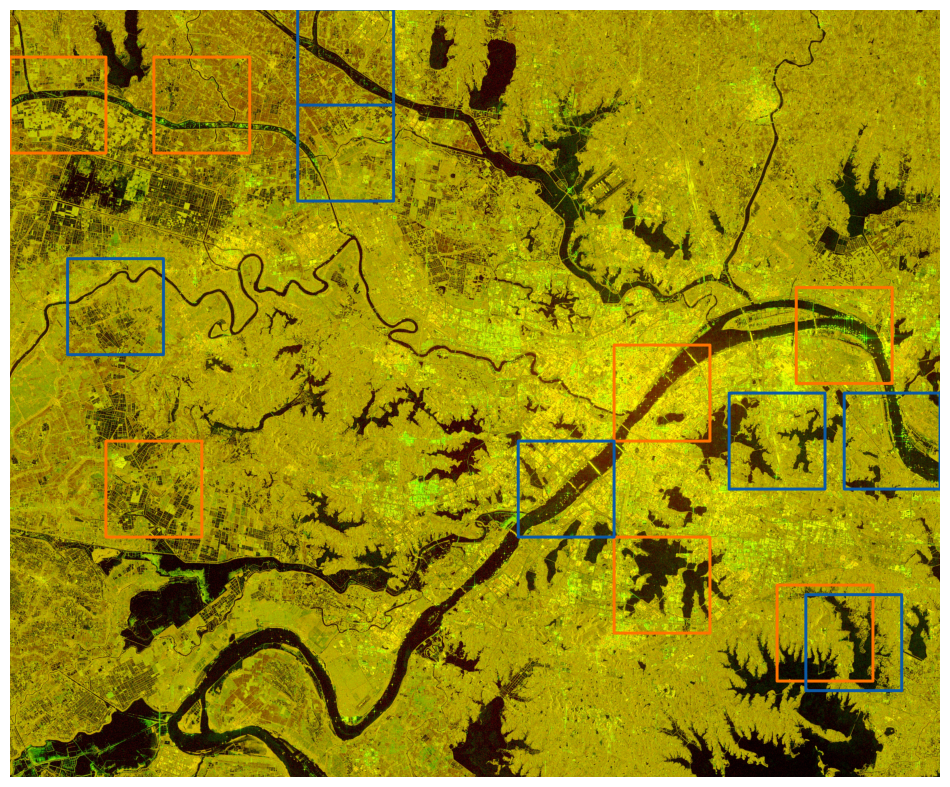

In [2]:
# 训练验证集范围  RANGE=[y1,y2,x1,x2]
RANGE_TRAIN = [
    [3500, 4500, 6300, 7300],   # 大桥梁、码头
    [5500, 6500, 6300, 7300],   # 小桥梁
    [4500, 5500, 1000, 2000],   # 暗区
    [6000, 7000, 8000, 9000],   # 复杂边缘
    [2900, 3900, 8200, 9200],   # 上面船舶
    [500, 1500, 0, 1000],   # 河流完整性
    [500, 1500, 1500, 2500],   # 小河流
]

# 测试集范围
RANGE_TEST = [
    [4500, 5500, 5300, 6300],   # 大桥梁、码头
    # [3500, 4500, 6300, 7300],   # 大桥梁、码头
    # [5500, 6500, 6300, 7300],   # 小桥梁
    [4000, 5000, 7500, 8500],   # 小桥梁
    # [4500, 5500, 1000, 2000],   # 暗区
    [2600, 3600, 600, 1600],   # 暗区
    # [6000, 7000, 8000, 9000],   # 复杂边缘
    [6100, 7100, 8300, 9300],   # 复杂边缘
    # [2900, 3900, 8200, 9200],   # 上面船舶
    [4000, 5000, 8700, 9700],   # 下面船舶
    # [500, 1500, 0, 1000],   # 河流完整性
    [0, 1000, 3000, 4000],   # 河流完整性
    [1000, 2000, 3000, 4000],   # 小河流
    # [500, 1500, 1500, 2500],       # 小河流
]

# 读取image
image = plt.imread(image_path) # VH, VV

# 读取label
label = plt.imread(label_path)
if label.max() <= 1.0:
    label = (label * 255).astype('u1')
label = cv2.cvtColor(label, cv2.COLOR_RGBA2GRAY)
_,label = cv2.threshold(label, 127, 255, cv2.THRESH_BINARY)

H,W = label.shape

Path('./dataset/').mkdir(exist_ok=True)
for i in Path('./dataset/').glob('*.*'):
    i.unlink()

image_rgb = image.copy()
label_rgb = cv2.cvtColor(label, cv2.COLOR_GRAY2RGB)
# 显示截取范围
for i in range(len(RANGE_TRAIN)):
    image_rgb = cv2.rectangle(image_rgb, (RANGE_TRAIN[i][2], RANGE_TRAIN[i][0]), (RANGE_TRAIN[i][3], RANGE_TRAIN[i][1]), (255,116,0), 30)
    # image_rgb = cv2.putText(image_rgb, str(i+1), (RANGE_TRAIN[i][2], RANGE_TRAIN[i][0]+250), cv2.FONT_HERSHEY_SIMPLEX, 10, (255,0,0), 20)
    label_rgb = cv2.rectangle(label_rgb, (RANGE_TRAIN[i][2], RANGE_TRAIN[i][0]), (RANGE_TRAIN[i][3], RANGE_TRAIN[i][1]), (255,0,0), 30)
    # label_rgb = cv2.putText(label_rgb, str(i+1), (RANGE_TRAIN[i][2], RANGE_TRAIN[i][0]+250), cv2.FONT_HERSHEY_SIMPLEX, 10, (255,0,0), 20)
for i in range(len(RANGE_TEST)):
    image_rgb = cv2.rectangle(image_rgb, (RANGE_TEST[i][2], RANGE_TEST[i][0]), (RANGE_TEST[i][3], RANGE_TEST[i][1]), (12,90,165), 30)
    # image_rgb = cv2.putText(image_rgb, str(i+1), (RANGE_TEST[i][2], RANGE_TEST[i][0]+500), cv2.FONT_HERSHEY_SIMPLEX, 10, (0,255,0), 20)
    label_rgb = cv2.rectangle(label_rgb, (RANGE_TEST[i][2], RANGE_TEST[i][0]), (RANGE_TEST[i][3], RANGE_TEST[i][1]), (0,255,0), 10)
    # label_rgb = cv2.putText(label_rgb, str(i+1), (RANGE_TEST[i][2], RANGE_TEST[i][0]+500), cv2.FONT_HERSHEY_SIMPLEX, 10, (0,255,0), 20)
plt.figure(figsize=(12,12)); plt.imshow(image_rgb); plt.axis('off'); plt.show()

In [3]:
# 截取研究区域图像
image_train_shots = []
label_train_shots = []
image_test_shots = []
label_test_shots = []
for i in range(len(RANGE_TRAIN)):
    image_shot = image[RANGE_TRAIN[i][0]:RANGE_TRAIN[i][1], RANGE_TRAIN[i][2]:RANGE_TRAIN[i][3]]
    label_shot = label[RANGE_TRAIN[i][0]:RANGE_TRAIN[i][1], RANGE_TRAIN[i][2]:RANGE_TRAIN[i][3]]
    image_train_shots.append(image_shot)
    label_train_shots.append(label_shot)
for i in range(len(RANGE_TEST)):
    image_shot = image[RANGE_TEST[i][0]:RANGE_TEST[i][1], RANGE_TEST[i][2]:RANGE_TEST[i][3]]
    label_shot = label[RANGE_TEST[i][0]:RANGE_TEST[i][1], RANGE_TEST[i][2]:RANGE_TEST[i][3]]
    image_test_shots.append(image_shot)
    label_test_shots.append(label_shot)

In [4]:
class MyColorJitter(object):
    """transforms.ColorJitter的hue会混合通道，这里保持通道独立性并改变颜色"""

    def __init__(self, brightness=0.15, contrast=0.25, saturation=0.25, k=0.35):
        self.colorJitter = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=0.0)
        self.k = k

    def __call__(self, img_pil: Image.Image) -> Image.Image:
        img = self.colorJitter(img_pil)
        img = np.array(img)
        assert img.dtype == np.uint8 and img.shape[2] == 3  # 三通道图像
        img = (img / 255 + np.random.random((1,1,3)) * self.k) * 255
        img = np.clip(img, 0, 255).astype(np.uint8)
        img = Image.fromarray(img)
        return img

In [5]:
# 根据训练数据区域，生成训练集
import torch
from torchvision import transforms

# 各区域参数
LENGTH = 512        # 小图片的宽/高
NUM = [400] * 7  # 图像数量
PAD = 250
RESIZE_FACTOR = 1

SIZE = LENGTH//RESIZE_FACTOR
trans_image = transforms.Compose([transforms.ToPILImage(),
                            transforms.Pad(PAD, padding_mode='reflect'),
                            transforms.RandomCrop(round(LENGTH*1.415)),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomRotation(180),     # -180~180
                            transforms.CenterCrop(LENGTH),
                            # transforms.Resize((SIZE,SIZE), interpolation=Image.NEAREST),
                            # transforms.ColorJitter(brightness=0.15, contrast=0.25, saturation=0.25, hue=0.06), # 1-x, 1+x
                            MyColorJitter(brightness=0.10, contrast=0.20, saturation=0.20, k=0.35), # 1-x, 1+x
                            ])
trans_mask = transforms.Compose([transforms.ToPILImage(),
                            transforms.Pad(PAD, padding_mode='reflect'),
                            transforms.RandomCrop(round(LENGTH*1.415)),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomRotation(180),     # -180~180
                            transforms.CenterCrop(LENGTH),
                            # transforms.Resize((SIZE,SIZE), interpolation=Image.NEAREST),
                            ])

img_root = Path('./dataset/trainval_imgs/')
mask_root = Path('./dataset/trainval_masks/')
if img_root.exists():
    shutil.rmtree(img_root)
if mask_root.exists():
    shutil.rmtree(mask_root)
img_root.mkdir()
mask_root.mkdir()

for n in range(len(RANGE_TRAIN)):

    # 混合的训练集
    img_path = img_root
    mask_path = mask_root
    # 分文件夹的训练集
    # img_path = img_root.joinpath(f'{n+1}')
    # img_path.mkdir(exist_ok=True)
    # mask_path = mask_root.joinpath(f'{n+1}')
    # mask_path.mkdir(exist_ok=True)

    for i in trange(NUM[n]):
        seed = i

        torch.random.manual_seed(seed)
        cropped_image: Image.Image = trans_image(image_train_shots[n])
        torch.random.manual_seed(seed)
        cropped_label: Image.Image = trans_mask(label_train_shots[n])

        cropped_label = np.array(cropped_label)
        kn = np.ones((3,3))
        cropped_label = cv2.morphologyEx(cropped_label, cv2.MORPH_OPEN, kn)
        cropped_label = cv2.morphologyEx(cropped_label, cv2.MORPH_CLOSE, kn)
        cropped_label = Image.fromarray(cropped_label)

        cropped_image.save(img_path / f'REGION={n+1:02d}&i={i:04d}.png', quality=95)
        cropped_label.save(mask_path / f'REGION={n+1:02d}&i={i:04d}_mask.png', quality=95)

d:\Software\Miniconda3\envs\pt_cu102\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 400/400 [01:13<00:00,  5.48it/s]


In [6]:
# 根据测试区域，生成测试集

# 各区域参数
NUM = [20] * len(RANGE_TEST)  # 图像数量

trans_image = transforms.Compose([transforms.ToPILImage(),
                            transforms.RandomCrop(round(LENGTH*1.415)),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomRotation(180),     # -180~180
                            transforms.CenterCrop(LENGTH),
                            # transforms.Resize((SIZE,SIZE), interpolation=Image.NEAREST),
                            # transforms.ColorJitter(brightness=0.15, contrast=0.25, saturation=0.25, hue=0.06), # 1-x, 1+x
                            ])
trans_mask = transforms.Compose([transforms.ToPILImage(),
                            transforms.RandomCrop(round(LENGTH*1.415)),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomRotation(180),     # -180~180
                            transforms.CenterCrop(LENGTH),
                            # transforms.Resize((SIZE,SIZE), interpolation=Image.NEAREST),
                            ])

img_root = Path('./dataset/test_imgs/')
mask_root = Path('./dataset/test_masks/')
if img_root.exists():
    shutil.rmtree(img_root)
if mask_root.exists():
    shutil.rmtree(mask_root)
img_root.mkdir()
mask_root.mkdir()

for n in range(len(RANGE_TEST)):
    for i in trange(NUM[n]):
        seed = i

        torch.random.manual_seed(seed)
        cropped_image: Image.Image = trans_image(image_test_shots[n])
        torch.random.manual_seed(seed)
        cropped_label: Image.Image = trans_mask(label_test_shots[n])

        # transforms选择会破坏mask
        cropped_label = np.array(cropped_label)
        kn = np.ones((3,3))
        cropped_label = cv2.morphologyEx(cropped_label, cv2.MORPH_OPEN, kn)
        cropped_label = cv2.morphologyEx(cropped_label, cv2.MORPH_CLOSE, kn)
        cropped_label = Image.fromarray(cropped_label)

        cropped_image.save(img_root / f'REGION={n+1:02d}&i={i:04d}.png', quality=95)
        cropped_label.save(mask_root / f'REGION={n+1:02d}&i={i:04d}_mask.png', quality=95)

100%|██████████| 20/20 [00:03<00:00,  6.11it/s]
